<a href="https://colab.research.google.com/github/iannwtf19/iannwtf19/blob/main/Week6/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tqdm

# 1. Download & Preprocess CIFAR-10

## Download CIFAR10 dataset
For this task we will use the CIFAR10 image dataset as our input. Let's download it as training and test datasets.

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {

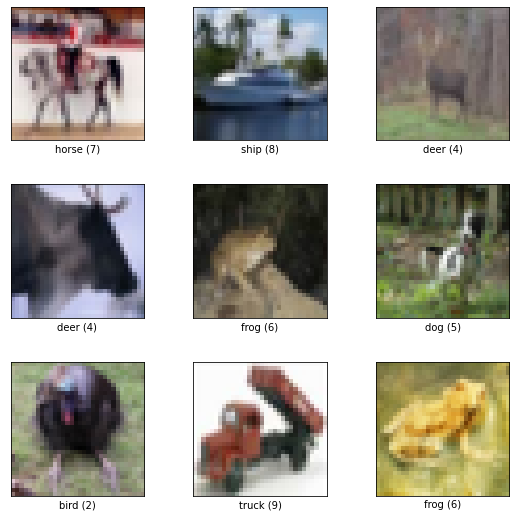

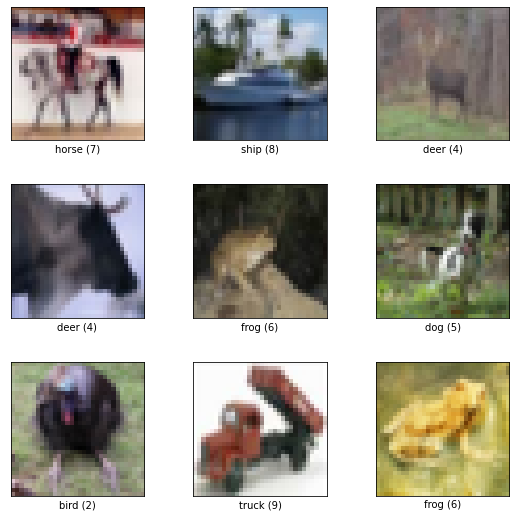

In [ ]:
(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
print(ds_info)
tfds.show_examples(train_ds, ds_info)

## Preprocessing

Let's define a function to preprocess the datasets, then call it to get our final training and testing datasets.

In [ ]:
def cifar_prepare(cifar):
    # Normalize image values to floats between 0 and 1
    cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32) / 128. -1, target))

    # Convert targets to one-hot vector
    cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # Shuffle, batch and prefetch
    cifar = cifar.shuffle(10000)
    cifar = cifar.batch(32)
    cifar = cifar.prefetch(tf.data.AUTOTUNE)

    cifar.cache()

    return cifar

# Preprocess the downloaded training and test datasets
train_ds = cifar_prepare(train_ds)
test_ds = cifar_prepare(test_ds)

# 2. Define common parameters

Let's define our common parameters that will be used for all models, like loss function, optimizer, metrics and number of epochs.

## Loss Function & Optimizer

Since our target will be one-hot vector, we use CategoricalCrossEntropy as the loss function. Alternatively, we could use integer targets and SparseCategoricalCrossEntropy, but since we have only 10 classes it seems fine to use the more familiar one-hot vector approach.

We use ADAM as the optimizer since it seems to be one of the best general-purpose choices.

In [ ]:
# Set loss function & optimizer
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## Metrics
We set training and test metrics separately so that we don't have to reset them after training and then testing again. We will reset each metric once per epoch.

In [ ]:
# Set metrics
train_loss_metrics = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_metrics = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss_metrics = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_metrics = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

## Hyperparameters - number of epochs

Let's define our number of epochs hyperparameter here. We will use the same number of epochs for each model, so that we can easily compare.
We set it to 15 since that should be enought to get a decent accuracy even for the basic model.

In [ ]:
num_epochs = 15

# 3. Model-agnostic Training Loop

Here we define our training loop before we actually define our model. We will use keras.Model class for all our models, so they will have common functions like train_step and test_step that we can reuse. We will base our training loop on that base class.

In [ ]:
def training_loop(model, num_epochs):
    # Lists to keep track of losses and accuracies
    training_losses = []
    training_accuracies = []
    test_losses = []
    test_accuracies = []

    # Get config name as name of the model class
    config_name = model.__class__.__name__

    print(f'Starting training for model {config_name}')
    for epoch in range(num_epochs):
        # Reset metrics before starting epoch
        train_loss_metrics.reset_states()
        train_accuracy_metrics.reset_states()
        test_loss_metrics.reset_states()
        test_accuracy_metrics.reset_states()

        # Loop over all batches of training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        training_losses.append(train_loss_metrics.result())
        training_accuracies.append(train_accuracy_metrics.result())

        # Loop over all batches of test data
        for data in test_ds:
            model.test_step(data)

        test_losses.append(test_loss_metrics.result())
        test_accuracies.append(test_accuracy_metrics.result())

        print(
            f'- Epoch {epoch + 1} - '
            f'Training Loss: {train_loss_metrics.result()}, '
            f'Training Accuracy: {train_accuracy_metrics.result()}, '
            f'Test Loss: {test_loss_metrics.result()}, '
            f'Test Accuracy: {test_accuracy_metrics.result()}'
        )

    # Visualize results
    plt.figure()
    line_train_loss, = plt.plot(training_losses)
    line_train_acc, = plt.plot(training_accuracies)
    line_test_loss, = plt.plot(test_losses)
    line_test_acc, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line_train_loss, line_train_acc, line_test_loss, line_test_acc),
                ("Training loss", "Training Accuracy", "Test loss", "Test Accuracy"))
    plt.show()

# 4. Let's have fun!

Now we can finally define different convolutional models and test their performance.

## Basic convolutional model

We start with a basic convolutional model that has 3 blocks: 2 convolutional layers with 32 filters + max pooling, then 2 convolutional layers with 64 filters + global average pooling and a Dense layer at the end as our readout layer.

In [ ]:
class ConvolutionModel(tf.keras.Model):

    def __init__(self):
        super(ConvolutionModel, self).__init__()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.pooling(x)
        x = self.convlayer2(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @tf.function
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            output = self(images, training=True)
            loss = loss_function(labels, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        train_loss_metrics.update_state(loss)
        train_accuracy_metrics.update_state(labels, output)

    @tf.function
    def test_step(self, data):
        images, labels = data
        output = self(images, training=False)
        loss = loss_function(labels, output)

        test_loss_metrics.update_state(loss)
        test_accuracy_metrics.update_state(labels, output)

### Train and visualize the results for the basic convolutional model

Starting training for model ConvolutionModel


100%|██████████| 782/782 [00:54<00:00, 14.37it/s]


- Epoch 1 - Training Loss: 2.033024311065674, Training Accuracy: 0.23917999863624573, Test Loss: 1.8860913515090942, Test Accuracy: 0.3100999891757965


100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


- Epoch 2 - Training Loss: 1.8340563774108887, Training Accuracy: 0.3125399947166443, Test Loss: 1.7773361206054688, Test Accuracy: 0.328000009059906


100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


- Epoch 3 - Training Loss: 1.747339129447937, Training Accuracy: 0.35128000378608704, Test Loss: 1.7073780298233032, Test Accuracy: 0.36800000071525574


100%|██████████| 782/782 [00:49<00:00, 15.69it/s]


- Epoch 4 - Training Loss: 1.7022631168365479, Training Accuracy: 0.370279997587204, Test Loss: 1.6897927522659302, Test Accuracy: 0.3741999864578247


100%|██████████| 782/782 [00:48<00:00, 16.22it/s]


- Epoch 5 - Training Loss: 1.665459394454956, Training Accuracy: 0.38741999864578247, Test Loss: 1.651659369468689, Test Accuracy: 0.3946000039577484


100%|██████████| 782/782 [00:50<00:00, 15.42it/s]


- Epoch 6 - Training Loss: 1.6401890516281128, Training Accuracy: 0.3970000147819519, Test Loss: 1.61166512966156, Test Accuracy: 0.41040000319480896


100%|██████████| 782/782 [00:49<00:00, 15.77it/s]


- Epoch 7 - Training Loss: 1.615632176399231, Training Accuracy: 0.4098599851131439, Test Loss: 1.5981425046920776, Test Accuracy: 0.41839998960494995


100%|██████████| 782/782 [00:48<00:00, 16.12it/s]


- Epoch 8 - Training Loss: 1.5949479341506958, Training Accuracy: 0.41920000314712524, Test Loss: 1.579321026802063, Test Accuracy: 0.42899999022483826


100%|██████████| 782/782 [00:48<00:00, 16.23it/s]


- Epoch 9 - Training Loss: 1.57462739944458, Training Accuracy: 0.42983999848365784, Test Loss: 1.5785752534866333, Test Accuracy: 0.4260999858379364


100%|██████████| 782/782 [00:49<00:00, 15.83it/s]


- Epoch 10 - Training Loss: 1.5555952787399292, Training Accuracy: 0.4359999895095825, Test Loss: 1.549772024154663, Test Accuracy: 0.4343000054359436


100%|██████████| 782/782 [00:48<00:00, 16.16it/s]


- Epoch 11 - Training Loss: 1.5368750095367432, Training Accuracy: 0.44426000118255615, Test Loss: 1.5191057920455933, Test Accuracy: 0.45339998602867126


100%|██████████| 782/782 [00:48<00:00, 16.06it/s]


- Epoch 12 - Training Loss: 1.5218803882598877, Training Accuracy: 0.4501200020313263, Test Loss: 1.4980168342590332, Test Accuracy: 0.4643000066280365


100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


- Epoch 13 - Training Loss: 1.5105233192443848, Training Accuracy: 0.45565998554229736, Test Loss: 1.4816645383834839, Test Accuracy: 0.4715000092983246


100%|██████████| 782/782 [00:49<00:00, 15.64it/s]


- Epoch 14 - Training Loss: 1.49519681930542, Training Accuracy: 0.45980000495910645, Test Loss: 1.4882478713989258, Test Accuracy: 0.4616999924182892


100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


- Epoch 15 - Training Loss: 1.485134482383728, Training Accuracy: 0.46404001116752625, Test Loss: 1.481119990348816, Test Accuracy: 0.46549999713897705


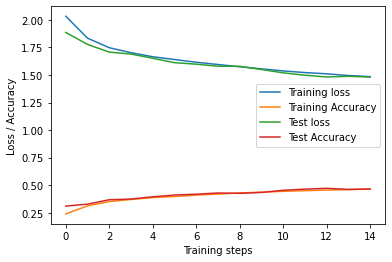

In [ ]:
training_loop(ConvolutionModel(), num_epochs)

## Residual Model

Let's try something different: A convolutional neural network with residual layers!

For this we define layer, block and model classes separately

### Residual Layer

In the call function, our layer will add the input to the output of the convolution.
This way the input will pass onto the next layer as a "residue".

In [ ]:
class ResidualConnectedCNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ResidualConnectedCNNLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

    def call(self, x):
        c = self.conv(x)
        # Add input to the output of the convolution
        x = c + x
        return x

### Residualy Connected Block

Our block will consist of a regular Conv2D layer, whose output will be passed on to the residual layers one after the other.

In [ ]:
class ResidualConnectedCNNBlock(tf.keras.layers.Layer):
    def __init__(self, depth, layers):
        super(ResidualConnectedCNNBlock, self).__init__()
        self.deeper_layer = tf.keras.layers.Conv2D(filters=depth, kernel_size=3, padding='same', activation='relu')
        self.layers = [ResidualConnectedCNNLayer(depth) for _ in range(layers)]

    def call(self, x):
        x = self.deeper_layer(x)
        for layer in self.layers:
            x = layer(x)
        return x

### Residually Connected Network

And one let's create our entire network, consisting of the residual blocks that we defined above

In [ ]:
class ResidualConnectedCNN(tf.keras.Model):
    def __init__(self):
        super(ResidualConnectedCNN, self).__init__()

        self.residualblock1 = ResidualConnectedCNNBlock(8, 2)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock2 = ResidualConnectedCNNBlock(16, 2)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock3 = ResidualConnectedCNNBlock(32, 2)
        self.globalpooling = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.residualblock1(x)
        x = self.pooling1(x)
        x = self.residualblock2(x)
        x = self.pooling2(x)
        x = self.residualblock3(x)
        x = self.globalpooling(x)
        x = self.out(x)
        return x

    @tf.function
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            output = self(images, training=True)
            loss = loss_function(labels, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        train_loss_metrics.update_state(loss)
        train_accuracy_metrics.update_state(labels, output)

    @tf.function
    def test_step(self, data):
        images, labels = data
        output = self(images, training=False)
        loss = loss_function(labels, output)

        test_loss_metrics.update_state(loss)
        test_accuracy_metrics.update_state(labels, output)

### Train and visualize results for the residually connected model

Starting training for model ResidualConnectedCNN


100%|██████████| 782/782 [00:10<00:00, 76.35it/s] 


- Epoch 1 - Training Loss: 1.7928210496902466, Training Accuracy: 0.32440000772476196, Test Loss: 1.5482985973358154, Test Accuracy: 0.4260999858379364


100%|██████████| 782/782 [00:05<00:00, 134.41it/s]


- Epoch 2 - Training Loss: 1.4733282327651978, Training Accuracy: 0.45201998949050903, Test Loss: 1.3567476272583008, Test Accuracy: 0.49880000948905945


100%|██████████| 782/782 [00:05<00:00, 137.59it/s]


- Epoch 3 - Training Loss: 1.337726354598999, Training Accuracy: 0.5104399919509888, Test Loss: 1.2676907777786255, Test Accuracy: 0.5408999919891357


100%|██████████| 782/782 [00:05<00:00, 138.51it/s]


- Epoch 4 - Training Loss: 1.2316479682922363, Training Accuracy: 0.553659975528717, Test Loss: 1.1696816682815552, Test Accuracy: 0.5819000005722046


100%|██████████| 782/782 [00:05<00:00, 134.66it/s]


- Epoch 5 - Training Loss: 1.150702953338623, Training Accuracy: 0.5835199952125549, Test Loss: 1.1455799341201782, Test Accuracy: 0.5875999927520752


100%|██████████| 782/782 [00:05<00:00, 137.74it/s]


- Epoch 6 - Training Loss: 1.0887397527694702, Training Accuracy: 0.6104400157928467, Test Loss: 1.0859748125076294, Test Accuracy: 0.6133999824523926


100%|██████████| 782/782 [00:05<00:00, 137.53it/s]


- Epoch 7 - Training Loss: 1.0432941913604736, Training Accuracy: 0.625540018081665, Test Loss: 1.0379172563552856, Test Accuracy: 0.6337000131607056


100%|██████████| 782/782 [00:05<00:00, 138.18it/s]


- Epoch 8 - Training Loss: 0.9967247843742371, Training Accuracy: 0.6434400081634521, Test Loss: 1.026611089706421, Test Accuracy: 0.6395999789237976


100%|██████████| 782/782 [00:05<00:00, 136.80it/s]


- Epoch 9 - Training Loss: 0.9640962481498718, Training Accuracy: 0.6560400128364563, Test Loss: 1.0934439897537231, Test Accuracy: 0.6133999824523926


100%|██████████| 782/782 [00:05<00:00, 136.63it/s]


- Epoch 10 - Training Loss: 0.9333997368812561, Training Accuracy: 0.6697999835014343, Test Loss: 0.9549993872642517, Test Accuracy: 0.6632000207901001


100%|██████████| 782/782 [00:05<00:00, 136.73it/s]


- Epoch 11 - Training Loss: 0.9078347086906433, Training Accuracy: 0.6788600087165833, Test Loss: 0.9533227682113647, Test Accuracy: 0.66839998960495


100%|██████████| 782/782 [00:06<00:00, 115.91it/s]


- Epoch 12 - Training Loss: 0.8758231997489929, Training Accuracy: 0.690500020980835, Test Loss: 0.9423109889030457, Test Accuracy: 0.6704000234603882


100%|██████████| 782/782 [00:08<00:00, 94.27it/s] 


- Epoch 13 - Training Loss: 0.8606430888175964, Training Accuracy: 0.6978200078010559, Test Loss: 0.9242479801177979, Test Accuracy: 0.6747000217437744


100%|██████████| 782/782 [00:08<00:00, 90.73it/s] 


- Epoch 14 - Training Loss: 0.8402824401855469, Training Accuracy: 0.7041800022125244, Test Loss: 0.9413278102874756, Test Accuracy: 0.6725000143051147


100%|██████████| 782/782 [00:07<00:00, 111.01it/s]


- Epoch 15 - Training Loss: 0.8190085291862488, Training Accuracy: 0.7097600102424622, Test Loss: 0.8919419050216675, Test Accuracy: 0.6855000257492065


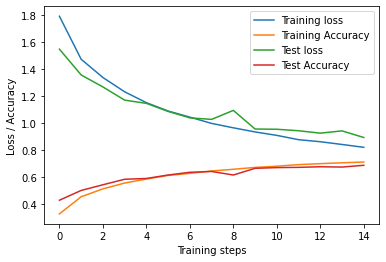

In [ ]:
training_loop(ResidualConnectedCNN(), num_epochs)

New Models for HW06

Our model underfits and does not perform well. 
First, we corrected the normalization. The model performs still not well enough.
Second,we add a new block and increase the number of filters to begin with. 

In [ ]:
class ResidualConnectedCNNPlus(tf.keras.Model):
    def __init__(self):
        super(ResidualConnectedCNNPlus, self).__init__()

        self.residualblock1 = ResidualConnectedCNNBlock(32, 2)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock2 = ResidualConnectedCNNBlock(64, 2)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock3 = ResidualConnectedCNNBlock(128, 2)
        self.pooling3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock4 = ResidualConnectedCNNBlock(256, 2)
        self.globalpooling = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.residualblock1(x)
        x = self.pooling1(x)
        x = self.residualblock2(x)
        x = self.pooling2(x)
        x = self.residualblock3(x)
        x = self.pooling3(x)
        x = self.residualblock4(x)
        x = self.globalpooling(x)
        x = self.out(x)
        return x

    @tf.function
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            output = self(images, training=True)
            loss = loss_function(labels, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        train_loss_metrics.update_state(loss)
        train_accuracy_metrics.update_state(labels, output)

    @tf.function
    def test_step(self, data):
        images, labels = data
        output = self(images, training=False)
        loss = loss_function(labels, output)

        test_loss_metrics.update_state(loss)
        test_accuracy_metrics.update_state(labels, output)

In [ ]:
training_loop(ResidualConnectedCNNPlus(), num_epochs)

Starting training for model ResidualConnectedCNNPlus


 10%|█         | 157/1563 [00:03<00:31, 45.09it/s] 


KeyboardInterrupt: ignored

We think the batch size was too large to learn effectively as the previous training loop resulted in not very good training accuracy. Therefore, we decrease the batch size from 64 to 32 to increase the stochasticity

Starting training for model ResidualConnectedCNNPlus


100%|██████████| 1563/1563 [00:13<00:00, 115.04it/s]


- Epoch 1 - Training Loss: 1.5635697841644287, Training Accuracy: 0.40803998708724976, Test Loss: 1.2130088806152344, Test Accuracy: 0.5543000102043152


100%|██████████| 1563/1563 [00:12<00:00, 124.82it/s]


- Epoch 2 - Training Loss: 1.0375313758850098, Training Accuracy: 0.6279199719429016, Test Loss: 1.0074355602264404, Test Accuracy: 0.6568999886512756


100%|██████████| 1563/1563 [00:11<00:00, 131.36it/s]


- Epoch 3 - Training Loss: 0.7995076179504395, Training Accuracy: 0.7182000279426575, Test Loss: 0.7839764952659607, Test Accuracy: 0.7297000288963318


100%|██████████| 1563/1563 [00:11<00:00, 132.12it/s]


- Epoch 4 - Training Loss: 0.6600804328918457, Training Accuracy: 0.7692000269889832, Test Loss: 0.7336929440498352, Test Accuracy: 0.7494000196456909


100%|██████████| 1563/1563 [00:11<00:00, 131.88it/s]


- Epoch 5 - Training Loss: 0.5647498369216919, Training Accuracy: 0.8006600141525269, Test Loss: 0.6858696341514587, Test Accuracy: 0.7620000243186951


100%|██████████| 1563/1563 [00:11<00:00, 132.39it/s]


- Epoch 6 - Training Loss: 0.47603607177734375, Training Accuracy: 0.8321800231933594, Test Loss: 0.7454042434692383, Test Accuracy: 0.7667999863624573


100%|██████████| 1563/1563 [00:11<00:00, 131.69it/s]


- Epoch 7 - Training Loss: 0.4033913314342499, Training Accuracy: 0.8564800024032593, Test Loss: 0.7342405319213867, Test Accuracy: 0.7723000049591064


100%|██████████| 1563/1563 [00:11<00:00, 130.55it/s]


- Epoch 8 - Training Loss: 0.3391945958137512, Training Accuracy: 0.8790199756622314, Test Loss: 0.7654058933258057, Test Accuracy: 0.7793999910354614


100%|██████████| 1563/1563 [00:12<00:00, 124.89it/s]


- Epoch 9 - Training Loss: 0.28603044152259827, Training Accuracy: 0.897159993648529, Test Loss: 0.8346737027168274, Test Accuracy: 0.7630000114440918


100%|██████████| 1563/1563 [00:12<00:00, 126.47it/s]


- Epoch 10 - Training Loss: 0.24690382182598114, Training Accuracy: 0.913320004940033, Test Loss: 0.940208375453949, Test Accuracy: 0.7635999917984009


100%|██████████| 1563/1563 [00:12<00:00, 125.97it/s]


- Epoch 11 - Training Loss: 0.21495045721530914, Training Accuracy: 0.9237200021743774, Test Loss: 0.9431887269020081, Test Accuracy: 0.776199996471405


100%|██████████| 1563/1563 [00:11<00:00, 131.34it/s]


- Epoch 12 - Training Loss: 0.1968221664428711, Training Accuracy: 0.9304999709129333, Test Loss: 0.9659805297851562, Test Accuracy: 0.7742999792098999


100%|██████████| 1563/1563 [00:11<00:00, 131.86it/s]


- Epoch 13 - Training Loss: 0.1749337613582611, Training Accuracy: 0.9384199976921082, Test Loss: 1.0792553424835205, Test Accuracy: 0.7692000269889832


100%|██████████| 1563/1563 [00:11<00:00, 130.84it/s]


- Epoch 14 - Training Loss: 0.15717917680740356, Training Accuracy: 0.9454799890518188, Test Loss: 1.1123013496398926, Test Accuracy: 0.7616000175476074


100%|██████████| 1563/1563 [00:11<00:00, 131.31it/s]


- Epoch 15 - Training Loss: 0.15481330454349518, Training Accuracy: 0.9462400078773499, Test Loss: 1.1849251985549927, Test Accuracy: 0.7642999887466431


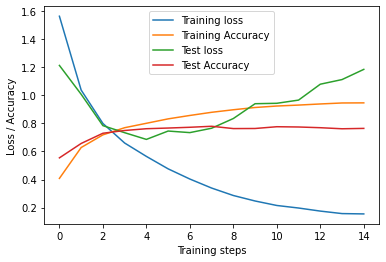

In [ ]:
training_loop(ResidualConnectedCNNPlus(), num_epochs)

After we decreased the batch size to 32, the learnability increased and now the model can learn better and faster. But now it overfits to the training data as seen from the training loss and test loss. 

Below, we increase the learning rate

In [ ]:
# Set loss function & optimizer
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

Starting training for model ResidualConnectedCNNPlus


100%|██████████| 1563/1563 [00:15<00:00, 98.25it/s] 


- Epoch 1 - Training Loss: 4.362174987792969, Training Accuracy: 0.26820001006126404, Test Loss: 1.6805893182754517, Test Accuracy: 0.37450000643730164


100%|██████████| 1563/1563 [00:11<00:00, 131.45it/s]


- Epoch 2 - Training Loss: 1.606745958328247, Training Accuracy: 0.40742000937461853, Test Loss: 1.5812945365905762, Test Accuracy: 0.4101000130176544


100%|██████████| 1563/1563 [00:11<00:00, 130.65it/s]


- Epoch 3 - Training Loss: 1.4879932403564453, Training Accuracy: 0.4572399854660034, Test Loss: 1.462250828742981, Test Accuracy: 0.4724000096321106


100%|██████████| 1563/1563 [00:11<00:00, 133.05it/s]


- Epoch 4 - Training Loss: 1.42483651638031, Training Accuracy: 0.4829599857330322, Test Loss: 1.4555643796920776, Test Accuracy: 0.4668999910354614


100%|██████████| 1563/1563 [00:11<00:00, 133.52it/s]


- Epoch 5 - Training Loss: 1.3843268156051636, Training Accuracy: 0.49873998761177063, Test Loss: 1.3622628450393677, Test Accuracy: 0.5074999928474426


100%|██████████| 1563/1563 [00:11<00:00, 133.47it/s]


- Epoch 6 - Training Loss: 1.3525598049163818, Training Accuracy: 0.5100600123405457, Test Loss: 1.3321670293807983, Test Accuracy: 0.5174000263214111


100%|██████████| 1563/1563 [00:11<00:00, 132.18it/s]


- Epoch 7 - Training Loss: 1.3342276811599731, Training Accuracy: 0.5166400074958801, Test Loss: 1.304261326789856, Test Accuracy: 0.5278000235557556


100%|██████████| 1563/1563 [00:12<00:00, 125.94it/s]


- Epoch 8 - Training Loss: 1.304474949836731, Training Accuracy: 0.5314000248908997, Test Loss: 1.3044031858444214, Test Accuracy: 0.52920001745224


100%|██████████| 1563/1563 [00:12<00:00, 126.56it/s]


- Epoch 9 - Training Loss: 1.2911638021469116, Training Accuracy: 0.5362799763679504, Test Loss: 1.3222253322601318, Test Accuracy: 0.5253000259399414


100%|██████████| 1563/1563 [00:11<00:00, 132.44it/s]


- Epoch 10 - Training Loss: 1.271565556526184, Training Accuracy: 0.5440199971199036, Test Loss: 1.332991600036621, Test Accuracy: 0.5178999900817871


100%|██████████| 1563/1563 [00:11<00:00, 133.50it/s]


- Epoch 11 - Training Loss: 1.2625588178634644, Training Accuracy: 0.5464800000190735, Test Loss: 1.2997941970825195, Test Accuracy: 0.5368000268936157


100%|██████████| 1563/1563 [00:11<00:00, 133.20it/s]


- Epoch 12 - Training Loss: 1.2394967079162598, Training Accuracy: 0.5558599829673767, Test Loss: 1.2476460933685303, Test Accuracy: 0.5530999898910522


100%|██████████| 1563/1563 [00:11<00:00, 132.93it/s]


- Epoch 13 - Training Loss: 1.2196345329284668, Training Accuracy: 0.5636799931526184, Test Loss: 1.2165472507476807, Test Accuracy: 0.5604000091552734


100%|██████████| 1563/1563 [00:12<00:00, 127.11it/s]


- Epoch 14 - Training Loss: 1.2125072479248047, Training Accuracy: 0.568120002746582, Test Loss: 1.2222474813461304, Test Accuracy: 0.564300000667572


100%|██████████| 1563/1563 [00:11<00:00, 132.60it/s]


- Epoch 15 - Training Loss: 1.2212512493133545, Training Accuracy: 0.5638999938964844, Test Loss: 1.2434839010238647, Test Accuracy: 0.5514000058174133


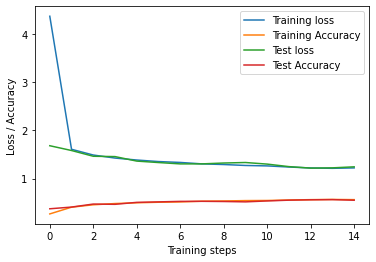

In [ ]:
training_loop(ResidualConnectedCNNPlus(), num_epochs)

Increasing the learning rate has resulted in not being able to finding the optimum. We decied to keep the learning rate at 0.001.

Next, we introduce a dropout layer

In [ ]:
class ResidualConnectedCNNDO(tf.keras.Model):
    def __init__(self):
        super(ResidualConnectedCNNDO, self).__init__()

        self.residualblock1 = ResidualConnectedCNNBlock(32, 2)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock2 = ResidualConnectedCNNBlock(64, 2)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        # Dropout layer introduced in between two layers

        self.dropoutlayer = tf.keras.layers.Dropout(0.5)

        self.residualblock3 = ResidualConnectedCNNBlock(128, 2)
        self.pooling3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock4 = ResidualConnectedCNNBlock(256, 2)
        self.globalpooling = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.residualblock1(x)
        x = self.pooling1(x)
        x = self.residualblock2(x)
        x = self.pooling2(x)
        x = self.dropoutlayer(x)
        x = self.residualblock3(x)
        x = self.pooling3(x)
        x = self.residualblock4(x)
        x = self.globalpooling(x)
        x = self.out(x)
        return x

    @tf.function
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            output = self(images, training=True)
            loss = loss_function(labels, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        train_loss_metrics.update_state(loss)
        train_accuracy_metrics.update_state(labels, output)

    @tf.function
    def test_step(self, data):
        images, labels = data
        output = self(images, training=False)
        loss = loss_function(labels, output)

        test_loss_metrics.update_state(loss)
        test_accuracy_metrics.update_state(labels, output)

Starting training for model ResidualConnectedCNNDO


100%|██████████| 1563/1563 [00:14<00:00, 108.16it/s]


- Epoch 1 - Training Loss: 1.6735646724700928, Training Accuracy: 0.37206000089645386, Test Loss: 1.3583192825317383, Test Accuracy: 0.5030999779701233


100%|██████████| 1563/1563 [00:14<00:00, 104.72it/s]


- Epoch 2 - Training Loss: 1.2003116607666016, Training Accuracy: 0.566100001335144, Test Loss: 1.0795122385025024, Test Accuracy: 0.6139000058174133


100%|██████████| 1563/1563 [00:12<00:00, 130.15it/s]


- Epoch 3 - Training Loss: 1.0191996097564697, Training Accuracy: 0.6384999752044678, Test Loss: 0.974947988986969, Test Accuracy: 0.6550999879837036


100%|██████████| 1563/1563 [00:11<00:00, 131.79it/s]


- Epoch 4 - Training Loss: 0.9025784134864807, Training Accuracy: 0.6798400282859802, Test Loss: 0.8279351592063904, Test Accuracy: 0.7092000246047974


100%|██████████| 1563/1563 [00:11<00:00, 131.54it/s]


- Epoch 5 - Training Loss: 0.8121217489242554, Training Accuracy: 0.7130600214004517, Test Loss: 0.8254473209381104, Test Accuracy: 0.7121000289916992


100%|██████████| 1563/1563 [00:13<00:00, 116.33it/s]


- Epoch 6 - Training Loss: 0.7424132227897644, Training Accuracy: 0.7373999953269958, Test Loss: 0.7876683473587036, Test Accuracy: 0.728600025177002


100%|██████████| 1563/1563 [00:12<00:00, 129.89it/s]


- Epoch 7 - Training Loss: 0.6803618669509888, Training Accuracy: 0.7609999775886536, Test Loss: 0.7192735075950623, Test Accuracy: 0.7576000094413757


100%|██████████| 1563/1563 [00:12<00:00, 130.06it/s]


- Epoch 8 - Training Loss: 0.6387327909469604, Training Accuracy: 0.7752400040626526, Test Loss: 0.7187560200691223, Test Accuracy: 0.7577999830245972


100%|██████████| 1563/1563 [00:12<00:00, 129.79it/s]


- Epoch 9 - Training Loss: 0.5959776639938354, Training Accuracy: 0.7887600064277649, Test Loss: 0.7061055302619934, Test Accuracy: 0.7628999948501587


100%|██████████| 1563/1563 [00:12<00:00, 127.34it/s]


- Epoch 10 - Training Loss: 0.5528592467308044, Training Accuracy: 0.8025199770927429, Test Loss: 0.8078657984733582, Test Accuracy: 0.7368000149726868


100%|██████████| 1563/1563 [00:12<00:00, 124.46it/s]


- Epoch 11 - Training Loss: 0.5206164717674255, Training Accuracy: 0.8145800232887268, Test Loss: 0.74908846616745, Test Accuracy: 0.7545999884605408


100%|██████████| 1563/1563 [00:13<00:00, 117.63it/s]


- Epoch 12 - Training Loss: 0.4926733076572418, Training Accuracy: 0.8264600038528442, Test Loss: 0.7450730204582214, Test Accuracy: 0.7572000026702881


100%|██████████| 1563/1563 [00:11<00:00, 130.72it/s]


- Epoch 13 - Training Loss: 0.46527373790740967, Training Accuracy: 0.8335199952125549, Test Loss: 0.7565086483955383, Test Accuracy: 0.751800000667572


100%|██████████| 1563/1563 [00:12<00:00, 130.14it/s]


- Epoch 14 - Training Loss: 0.4373593330383301, Training Accuracy: 0.8441399931907654, Test Loss: 0.7615063786506653, Test Accuracy: 0.760699987411499


100%|██████████| 1563/1563 [00:12<00:00, 130.10it/s]


- Epoch 15 - Training Loss: 0.4164525866508484, Training Accuracy: 0.8518999814987183, Test Loss: 0.8138967752456665, Test Accuracy: 0.7524999976158142


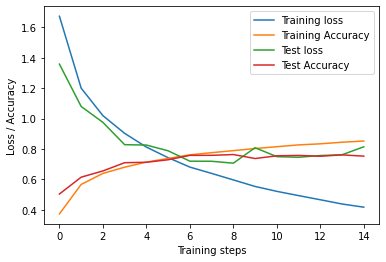

In [ ]:
training_loop(ResidualConnectedCNNDO(), num_epochs)

To increase the learnability, we added batch normalization after every layer before the pooling layer. Moreover, we add a dense layer before the output layer to make the model a fully connected network

In [ ]:
class ResidualConnectedCNNFCN(tf.keras.Model):
    def __init__(self):
        super(ResidualConnectedCNNFCN, self).__init__()

        self.residualblock1 = ResidualConnectedCNNBlock(32, 2)
        self.batchnormalization1 = tf.keras.layers.BatchNormalization() 
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock2 = ResidualConnectedCNNBlock(64, 2)
        self.batchnormalization2 = tf.keras.layers.BatchNormalization() 
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        

        

        self.residualblock3 = ResidualConnectedCNNBlock(128, 2)
        self.batchnormalization3 = tf.keras.layers.BatchNormalization() 
        self.pooling3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock4 = ResidualConnectedCNNBlock(256, 2)
        self.batchnormalization4 = tf.keras.layers.BatchNormalization() 
        self.globalpooling = tf.keras.layers.GlobalAvgPool2D()

        # Dropout layer introduced in between two layers
        self.dropoutlayer = tf.keras.layers.Dropout(0.5)

        self.fcnlayer = tf.keras.layers.Dense(256, activation='relu')

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.residualblock1(x)
        x = self.pooling1(x)
        x = self.batchnormalization1(x)
        x = self.residualblock2(x)
        x = self.pooling2(x)
        x = self.batchnormalization2(x)
        x = self.dropoutlayer(x)
        x = self.residualblock3(x)
        x = self.pooling3(x)
        x = self.batchnormalization3(x)
        x = self.residualblock4(x)
        x = self.batchnormalization4(x)
        x = self.globalpooling(x)
        x = self.fcnlayer(x)
        x = self.out(x)
        return x

    @tf.function
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            output = self(images, training=True)
            loss = loss_function(labels, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        train_loss_metrics.update_state(loss)
        train_accuracy_metrics.update_state(labels, output)

    @tf.function
    def test_step(self, data):
        images, labels = data
        output = self(images, training=False)
        loss = loss_function(labels, output)

        test_loss_metrics.update_state(loss)
        test_accuracy_metrics.update_state(labels, output)

Starting training for model ResidualConnectedCNNFCN


100%|██████████| 1563/1563 [00:14<00:00, 105.80it/s]


- Epoch 1 - Training Loss: 1.2776029109954834, Training Accuracy: 0.5356600284576416, Test Loss: 1.373756766319275, Test Accuracy: 0.5559999942779541


100%|██████████| 1563/1563 [00:12<00:00, 122.24it/s]


- Epoch 2 - Training Loss: 0.8440650701522827, Training Accuracy: 0.704800009727478, Test Loss: 0.7525544166564941, Test Accuracy: 0.7394999861717224


100%|██████████| 1563/1563 [00:12<00:00, 123.80it/s]


- Epoch 3 - Training Loss: 0.684545636177063, Training Accuracy: 0.7598599791526794, Test Loss: 0.7417579889297485, Test Accuracy: 0.7433000206947327


100%|██████████| 1563/1563 [00:12<00:00, 123.69it/s]


- Epoch 4 - Training Loss: 0.5932686924934387, Training Accuracy: 0.7934200167655945, Test Loss: 0.602787971496582, Test Accuracy: 0.7907000184059143


100%|██████████| 1563/1563 [00:13<00:00, 114.39it/s]


- Epoch 5 - Training Loss: 0.5254204273223877, Training Accuracy: 0.8186200261116028, Test Loss: 0.6075533032417297, Test Accuracy: 0.792900025844574


100%|██████████| 1563/1563 [00:12<00:00, 124.87it/s]


- Epoch 6 - Training Loss: 0.4647727310657501, Training Accuracy: 0.8375999927520752, Test Loss: 0.5694276690483093, Test Accuracy: 0.8093000054359436


100%|██████████| 1563/1563 [00:12<00:00, 124.30it/s]


- Epoch 7 - Training Loss: 0.41553831100463867, Training Accuracy: 0.8550400137901306, Test Loss: 0.5644749402999878, Test Accuracy: 0.8166000247001648


100%|██████████| 1563/1563 [00:12<00:00, 123.69it/s]


- Epoch 8 - Training Loss: 0.37063655257225037, Training Accuracy: 0.8696799874305725, Test Loss: 0.5297628045082092, Test Accuracy: 0.8255000114440918


100%|██████████| 1563/1563 [00:12<00:00, 123.47it/s]


- Epoch 9 - Training Loss: 0.3355414867401123, Training Accuracy: 0.8821200132369995, Test Loss: 0.5649758577346802, Test Accuracy: 0.8252000212669373


100%|██████████| 1563/1563 [00:13<00:00, 117.62it/s]


- Epoch 10 - Training Loss: 0.2981332242488861, Training Accuracy: 0.8943799734115601, Test Loss: 0.5820691585540771, Test Accuracy: 0.8220999836921692


100%|██████████| 1563/1563 [00:12<00:00, 124.62it/s]


- Epoch 11 - Training Loss: 0.27022865414619446, Training Accuracy: 0.9057199954986572, Test Loss: 0.6023287773132324, Test Accuracy: 0.8181999921798706


100%|██████████| 1563/1563 [00:12<00:00, 124.40it/s]


- Epoch 12 - Training Loss: 0.24609501659870148, Training Accuracy: 0.9128599762916565, Test Loss: 0.5573819279670715, Test Accuracy: 0.8334000110626221


100%|██████████| 1563/1563 [00:12<00:00, 123.73it/s]


- Epoch 13 - Training Loss: 0.22075045108795166, Training Accuracy: 0.9211400151252747, Test Loss: 0.5692868232727051, Test Accuracy: 0.8338000178337097


100%|██████████| 1563/1563 [00:12<00:00, 123.75it/s]


- Epoch 14 - Training Loss: 0.20373409986495972, Training Accuracy: 0.9269599914550781, Test Loss: 0.5579441785812378, Test Accuracy: 0.8414999842643738


100%|██████████| 1563/1563 [00:12<00:00, 122.59it/s]


- Epoch 15 - Training Loss: 0.18445295095443726, Training Accuracy: 0.9333599805831909, Test Loss: 0.6316208243370056, Test Accuracy: 0.8323000073432922


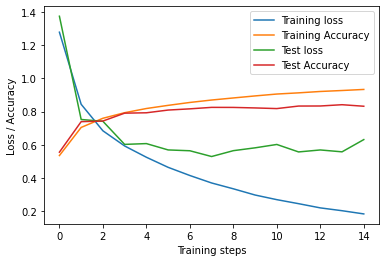

In [ ]:
training_loop(ResidualConnectedCNNFCN(), num_epochs)

In [ ]:
class ResidualConnectedCNNFCN2(tf.keras.Model):
    def __init__(self):
        super(ResidualConnectedCNNFCN2, self).__init__()

        self.residualblock1 = ResidualConnectedCNNBlock(32, 2)
        self.batchnormalization1 = tf.keras.layers.BatchNormalization() 
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock2 = ResidualConnectedCNNBlock(64, 2)
        self.batchnormalization2 = tf.keras.layers.BatchNormalization() 
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)      

        
        self.residualblock3 = ResidualConnectedCNNBlock(128, 2)
        self.batchnormalization3 = tf.keras.layers.BatchNormalization() 
        self.pooling3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.residualblock4 = ResidualConnectedCNNBlock(256, 2)
        self.batchnormalization4 = tf.keras.layers.BatchNormalization() 
        self.globalpooling = tf.keras.layers.GlobalAvgPool2D()

        # Dropout layer introduced in between two layers
        self.dropoutlayer1 = tf.keras.layers.Dropout(0.5)

        self.fcnlayer = tf.keras.layers.Dense(256, activation='relu')

        self.dropoutlayer2 = tf.keras.layers.Dropout(0.5)

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.residualblock1(x)
        x = self.pooling1(x)
        x = self.batchnormalization1(x)
        x = self.residualblock2(x)
        x = self.pooling2(x)
        x = self.batchnormalization2(x)        
        x = self.residualblock3(x)
        x = self.pooling3(x)
        x = self.batchnormalization3(x)
        x = self.residualblock4(x)
        x = self.batchnormalization4(x)
        x = self.globalpooling(x)
        x = self.dropoutlayer1(x)
        x = self.fcnlayer(x)
        x = self.dropoutlayer2(x)
        x = self.out(x)
        return x

    @tf.function
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            output = self(images, training=True)
            loss = loss_function(labels, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        train_loss_metrics.update_state(loss)
        train_accuracy_metrics.update_state(labels, output)

    @tf.function
    def test_step(self, data):
        images, labels = data
        output = self(images, training=False)
        loss = loss_function(labels, output)

        test_loss_metrics.update_state(loss)
        test_accuracy_metrics.update_state(labels, output)

Starting training for model ResidualConnectedCNNFCN2


100%|██████████| 1563/1563 [00:14<00:00, 107.57it/s]


- Epoch 1 - Training Loss: 1.6768962144851685, Training Accuracy: 0.38317999243736267, Test Loss: 1.3670076131820679, Test Accuracy: 0.4993000030517578


100%|██████████| 1563/1563 [00:14<00:00, 109.03it/s]


- Epoch 2 - Training Loss: 1.174528956413269, Training Accuracy: 0.5798599720001221, Test Loss: 0.9846203327178955, Test Accuracy: 0.6471999883651733


100%|██████████| 1563/1563 [00:13<00:00, 117.66it/s]


- Epoch 3 - Training Loss: 0.9484649300575256, Training Accuracy: 0.6654199957847595, Test Loss: 0.9326074123382568, Test Accuracy: 0.6793000102043152


100%|██████████| 1563/1563 [00:14<00:00, 109.89it/s]


- Epoch 4 - Training Loss: 0.799376368522644, Training Accuracy: 0.7228999733924866, Test Loss: 0.8035522699356079, Test Accuracy: 0.7228999733924866


100%|██████████| 1563/1563 [00:12<00:00, 124.97it/s]


- Epoch 5 - Training Loss: 0.6912413239479065, Training Accuracy: 0.7625399827957153, Test Loss: 0.7116510272026062, Test Accuracy: 0.7598000168800354


100%|██████████| 1563/1563 [00:12<00:00, 123.50it/s]


- Epoch 6 - Training Loss: 0.6026750206947327, Training Accuracy: 0.7942000031471252, Test Loss: 0.6638094186782837, Test Accuracy: 0.7753999829292297


100%|██████████| 1563/1563 [00:12<00:00, 124.27it/s]


- Epoch 7 - Training Loss: 0.5319614410400391, Training Accuracy: 0.8181399703025818, Test Loss: 0.6903799772262573, Test Accuracy: 0.7797999978065491


100%|██████████| 1563/1563 [00:13<00:00, 117.01it/s]


- Epoch 8 - Training Loss: 0.47068965435028076, Training Accuracy: 0.8394799828529358, Test Loss: 0.7218167781829834, Test Accuracy: 0.7789000272750854


100%|██████████| 1563/1563 [00:12<00:00, 124.78it/s]


- Epoch 9 - Training Loss: 0.41727733612060547, Training Accuracy: 0.8586400151252747, Test Loss: 0.6299500465393066, Test Accuracy: 0.8054999709129333


100%|██████████| 1563/1563 [00:12<00:00, 124.44it/s]


- Epoch 10 - Training Loss: 0.36933770775794983, Training Accuracy: 0.874239981174469, Test Loss: 0.6156563758850098, Test Accuracy: 0.8077999949455261


100%|██████████| 1563/1563 [00:12<00:00, 124.77it/s]


- Epoch 11 - Training Loss: 0.3257495164871216, Training Accuracy: 0.8901000022888184, Test Loss: 0.6900869011878967, Test Accuracy: 0.8019999861717224


100%|██████████| 1563/1563 [00:12<00:00, 123.60it/s]


- Epoch 12 - Training Loss: 0.28110823035240173, Training Accuracy: 0.9047399759292603, Test Loss: 0.6597564816474915, Test Accuracy: 0.8065999746322632


100%|██████████| 1563/1563 [00:12<00:00, 124.65it/s]


- Epoch 13 - Training Loss: 0.2511312663555145, Training Accuracy: 0.9151800274848938, Test Loss: 0.6587865352630615, Test Accuracy: 0.8205000162124634


100%|██████████| 1563/1563 [00:12<00:00, 123.85it/s]


- Epoch 14 - Training Loss: 0.22056731581687927, Training Accuracy: 0.9241999983787537, Test Loss: 0.7871576547622681, Test Accuracy: 0.7989000082015991


100%|██████████| 1563/1563 [00:12<00:00, 123.85it/s]


- Epoch 15 - Training Loss: 0.19472520053386688, Training Accuracy: 0.9343400001525879, Test Loss: 0.7600722908973694, Test Accuracy: 0.8065999746322632


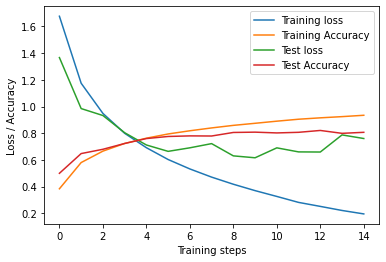

In [ ]:
training_loop(ResidualConnectedCNNFCN2(), num_epochs)